# Music Genre Classification with CNN

## Load Data

In [1]:
import os

# Define the path
audio_dir = 'Dataset/genres_original'
audio_files = os.listdir(audio_dir)

# Check all the files inside audio_files
print(f"Audio Files: {audio_files[:]}")

Audio Files: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


**Note**: 
* We are not using the images_original folder since we are going to split the genres_original into train, test, val splits. 
* Then, we are going to generate the spectrogram images by ourselves.
* So, we didn't load any images_original dataset here.  

In [2]:
import pandas as pd

# Load the feature files
df_30_sec = pd.read_csv('Dataset/features_30_sec.csv')
df_3_sec = pd.read_csv('Dataset/features_3_sec.csv')
missing_30_sec = df_30_sec.isnull().sum()
missing_3_sec = df_3_sec.isnull().sum()

# Check a few rows of the dataframes
print(f"30 Sec Features: {df_30_sec.head()}")
print(f"3 Sec Features: {df_3_sec.head()}")

30 Sec Features:           filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              20

## Data Cleaning

### Clean audio dataset

**Note**
* We are using `librosa` library for handling and checking audio files so that there are no corrupted files when we later try to convert them into spectrogram images. 
* Then we are going to find any corrupted or unreadable audio files, and make sure all audio files have length ~30 seconds (+/- 1 sec). 
* Finally, we will remove any corrupted files from genres_original folder

In [ ]:
import os
import librosa

# Cleaning parameters
expected_sr = 22050 # Set to default sample rate (how many audio samples are recorded per second)of librosa
target_duration = 30  # seconds
tolerance = 1         # +/- 1 second

# To store valid files and problems
clean_files = []
corrupt_files = []
duration_issues = []

# Walk through genres
for genre in os.listdir(audio_dir):
    genre_path = os.path.join(audio_dir, genre)
    if not os.path.isdir(genre_path):
        continue

    for file in os.listdir(genre_path):
        if not file.endswith('.wav'):
            continue

        file_path = os.path.join(genre_path, file)

        try:
            y, sr = librosa.load(file_path, sr=expected_sr)
            duration = librosa.get_duration(y=y, sr=sr)

            if abs(duration - target_duration) > tolerance:
                duration_issues.append(file_path)
                continue

            clean_files.append(file_path)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            corrupt_files.append(file_path)

In [4]:
print(f"Clean files: {len(clean_files)}")
print(f"Duration issues: {len(duration_issues)}")
print(f"Corrupt files: {len(corrupt_files)}")

Clean files: 999
Duration issues: 0
Corrupt files: 0


In [5]:
# Remove bad files from the original path
for f in corrupt_files + duration_issues:
    os.remove(f)
    print(f"Deleted: {f}")

In [6]:
# Remove jazz.00054.wav from the features_30_sec.csv
df_30_sec = df_30_sec[~df_30_sec['filename'].str.contains('jazz.00054')]

### Handle missing values from features datasets

In [7]:
# Check for missing values
print(df_30_sec.isnull().sum())
print("Missing values in features_30_sec.csv:")
print(missing_30_sec[missing_30_sec > 0])

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

In [8]:
print(df_3_sec.isnull().sum())
print("\nMissing values in featuers_3_sec.csv:")
print(missing_3_sec[missing_3_sec > 0])

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

### Drop duplicates

In [9]:
# Check if there are any duplicates
print("Duplicates in 30-sec:", df_30_sec.duplicated().sum())
print("Duplicates in 3-sec:", df_3_sec.duplicated().sum())

Duplicates in 30-sec: 0
Duplicates in 3-sec: 0


In [10]:
df_30_sec.drop_duplicates(inplace=True)
df_3_sec.drop_duplicates(inplace=True)

### Detect outliers

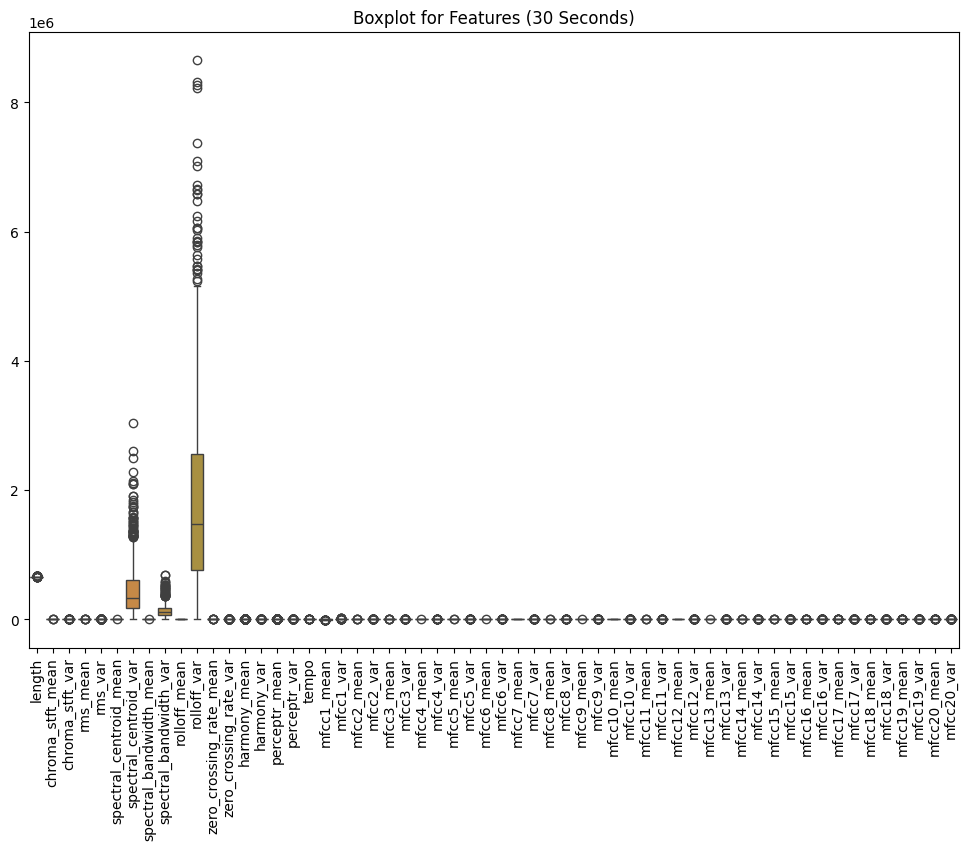

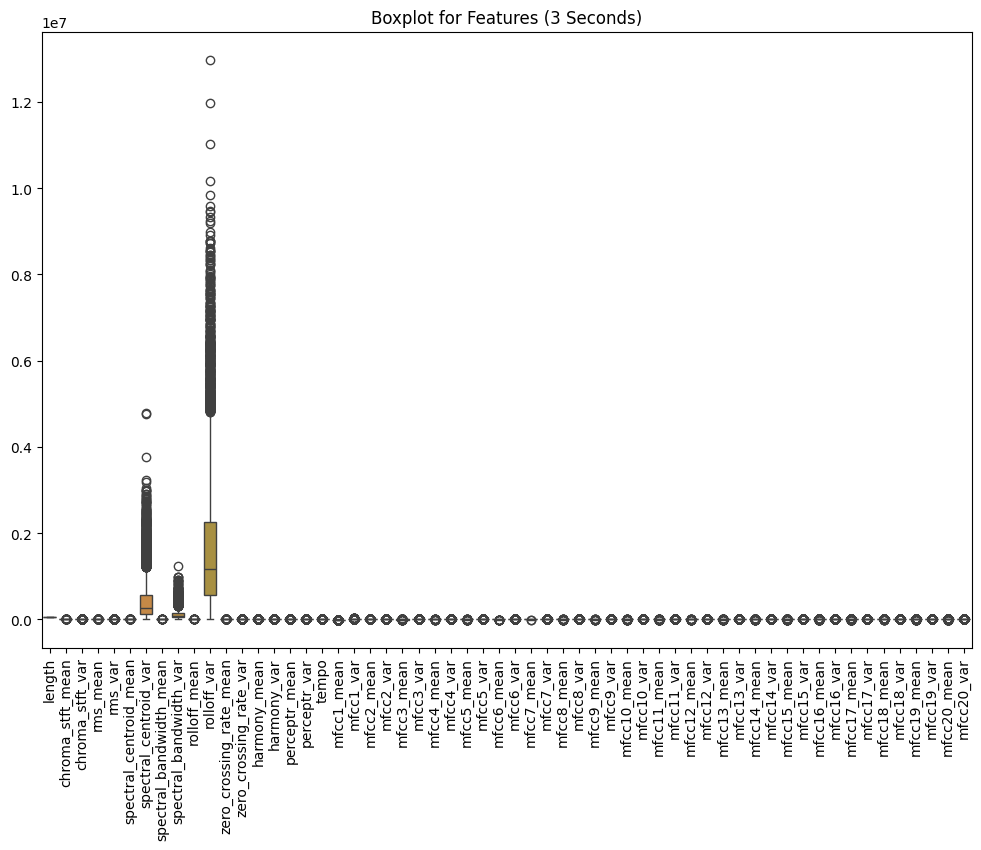

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# For the 30-second features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_30_sec)
plt.title('Boxplot for Features (30 Seconds)')
plt.xticks(rotation=90)
plt.show()

# For the 3-second features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_3_sec)
plt.title('Boxplot for Features (3 Seconds)')
plt.xticks(rotation=90)
plt.show()

### Remove outliers using Z-score and Isolation Forest

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

# Apply Z-score Outlier Removal for 30-second features
z_scores_30_sec = df_30_sec.select_dtypes(include=[np.number]).apply(zscore)

# Set threshold
threshold = 3

# Remove outliers for the 30-second features based on Z-scores
mask_30_sec = (abs(z_scores_30_sec) <= threshold)  # Only keep rows where Z-scores are <= 3

# Filter rows where all features are within the threshold
features_30_sec_clean = df_30_sec[mask_30_sec.all(axis=1)]  

# Show before and after shapes
print(f"Original 30-second features shape: {df_30_sec.shape}")
print(f"After removing outliers 30-second features shape: {features_30_sec_clean.shape}")

# Apply Isolation Forest for 3-second features
iso_forest_3sec = IsolationForest(contamination=0.05, random_state=42)  # 5% of data is expected to be outliers

# Fit the model and predict outliers
outliers_3_sec = iso_forest_3sec.fit_predict(df_3_sec.select_dtypes(include=[np.number]))

# Convert -1 (outlier) to boolean True, 1 (inlier) to boolean False
mask_3_sec = outliers_3_sec == 1

# Filter the data based on the outlier prediction
features_3_sec_clean = df_3_sec[mask_3_sec]

# Show before and after shapes
print(f"Original 3-second features shape: {df_3_sec.shape}")
print(f"After removing outliers 3-second features shape: {features_3_sec_clean.shape}")

Original 30-second features shape: (999, 60)
After removing outliers 30-second features shape: (718, 60)
Original 3-second features shape: (9990, 60)
After removing outliers 3-second features shape: (9490, 60)


In [13]:
# Confirm the number of features after cleaning
df_30_sec=features_30_sec_clean
df_3_sec=features_3_sec_clean
df_3_sec.drop_duplicates(inplace=True)
df_30_sec.drop_duplicates(inplace=True)
print("3-sec features:", df_3_sec.shape[0])
print("30-sec features:", df_30_sec.shape[0])

3-sec features: 9490
30-sec features: 718


In [14]:
df_30_sec.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [15]:
df_3_sec.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

## Data Exploration

### Check datatypes

In [16]:
print(df_30_sec.dtypes)

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [17]:
print(df_3_sec.dtypes)

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

### Apply statistical methods

In [18]:
# Get statistical summaries of numerical columns
print(df_30_sec.describe())

              length  chroma_stft_mean  chroma_stft_var    rms_mean  \
count     718.000000        718.000000       718.000000  718.000000   
mean   661764.384401          0.382268         0.085670    0.129238   
std       492.465980          0.072301         0.006784    0.058606   
min    660000.000000          0.187064         0.063166    0.009495   
25%    661504.000000          0.330250         0.081824    0.090537   
50%    661794.000000          0.384508         0.086092    0.120042   
75%    661794.000000          0.433902         0.090165    0.170148   
max    666820.000000          0.583706         0.103829    0.293576   

          rms_var  spectral_centroid_mean  spectral_centroid_var  \
count  718.000000              718.000000           7.180000e+02   
mean     0.002430             2192.097306           3.983276e+05   
std      0.002231              666.728637           2.906904e+05   
min      0.000004              570.040355           2.142404e+04   
25%      0.000977   

In [19]:
# Get statistical summaries of numerical columns
print(df_3_sec.describe())

        length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9490.0       9490.000000      9490.000000  9490.000000  9.490000e+03   
mean   66149.0          0.381748         0.084562     0.130019  2.445671e-03   
std        0.0          0.087858         0.009380     0.066294  3.048690e-03   
min    66149.0          0.116085         0.038064     0.000953  4.379535e-08   
25%    66149.0          0.320436         0.079608     0.084585  6.142311e-04   
50%    66149.0          0.386194         0.084843     0.120833  1.468981e-03   
75%    66149.0          0.442734         0.090693     0.174470  2.957401e-03   
max    66149.0          0.738563         0.120964     0.378848  3.084911e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9490.000000           9.490000e+03              9490.000000   
mean              2179.693739           3.881789e+05              2233.729520   
std                723.789252       

### Visualization

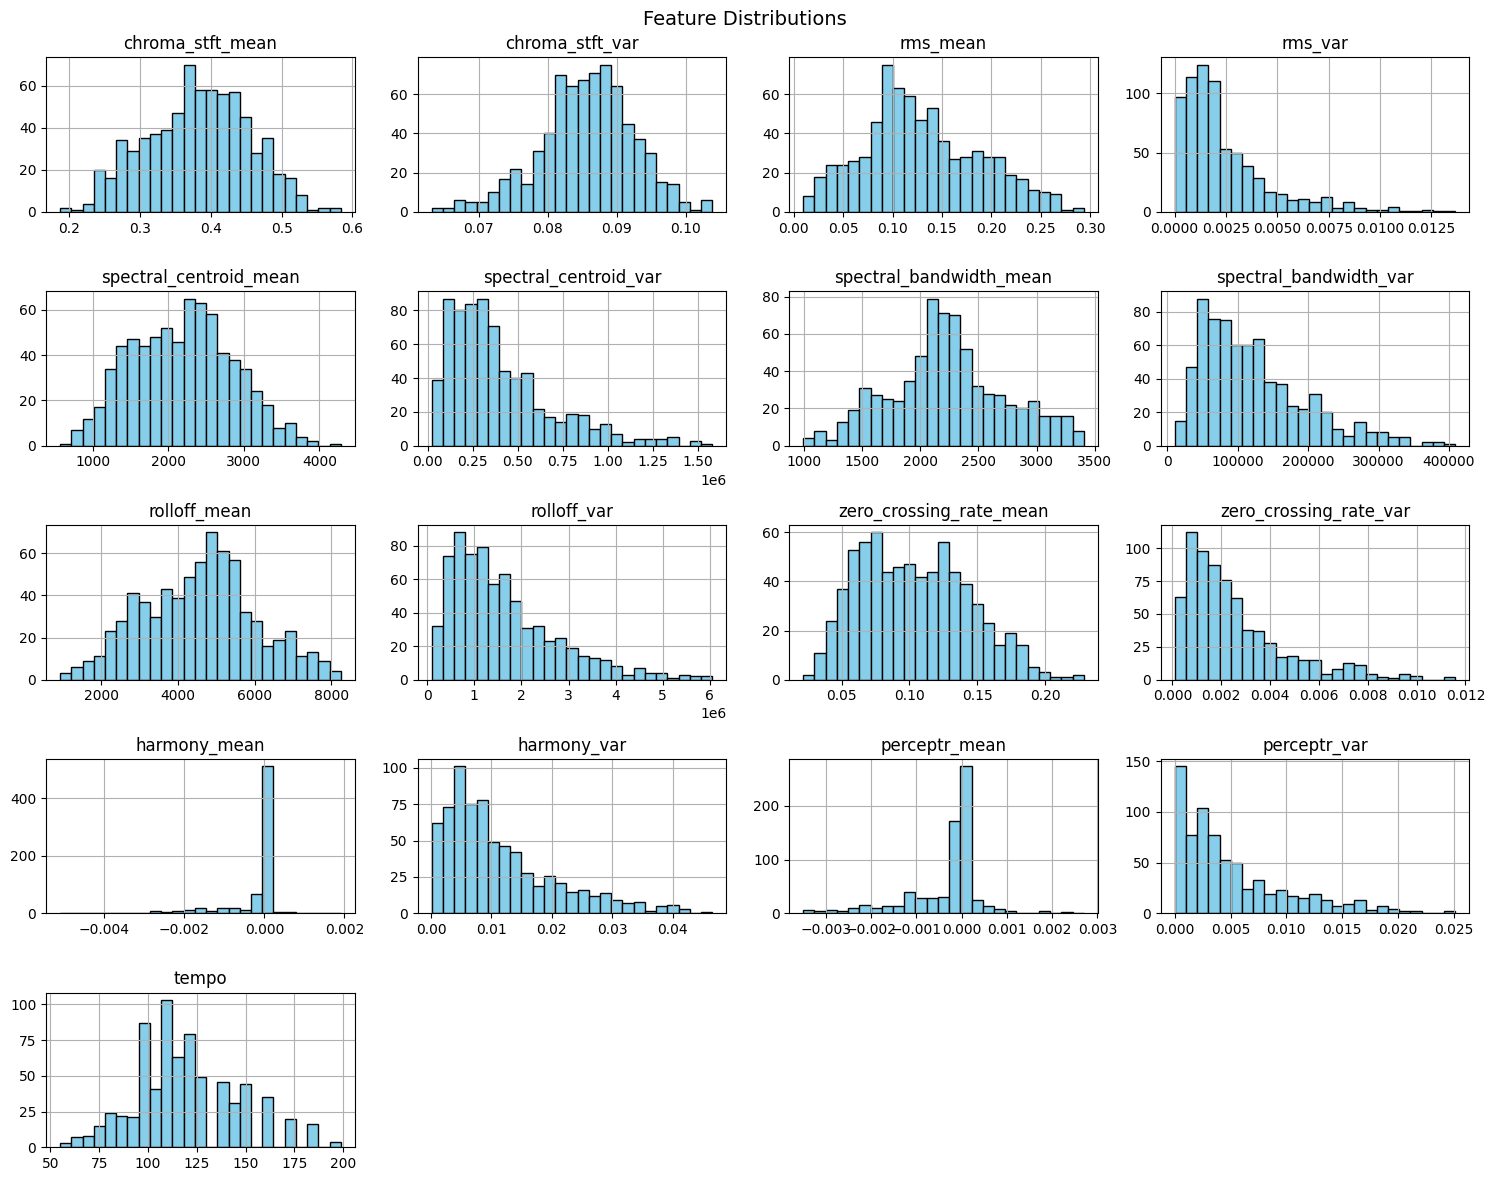

In [20]:
# Plot histogram of spectral features
filtered_features = [
    'chroma_stft_mean', 'chroma_stft_var',
    'rms_mean', 'rms_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'spectral_bandwidth_mean', 'spectral_bandwidth_var',
    'rolloff_mean', 'rolloff_var',
    'zero_crossing_rate_mean', 'zero_crossing_rate_var',
    'harmony_mean', 'harmony_var',
    'perceptr_mean', 'perceptr_var',
    'tempo']

df_30_sec[filtered_features].hist(bins=25, figsize=(15, 12), color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14)
plt.tight_layout()
plt.show()

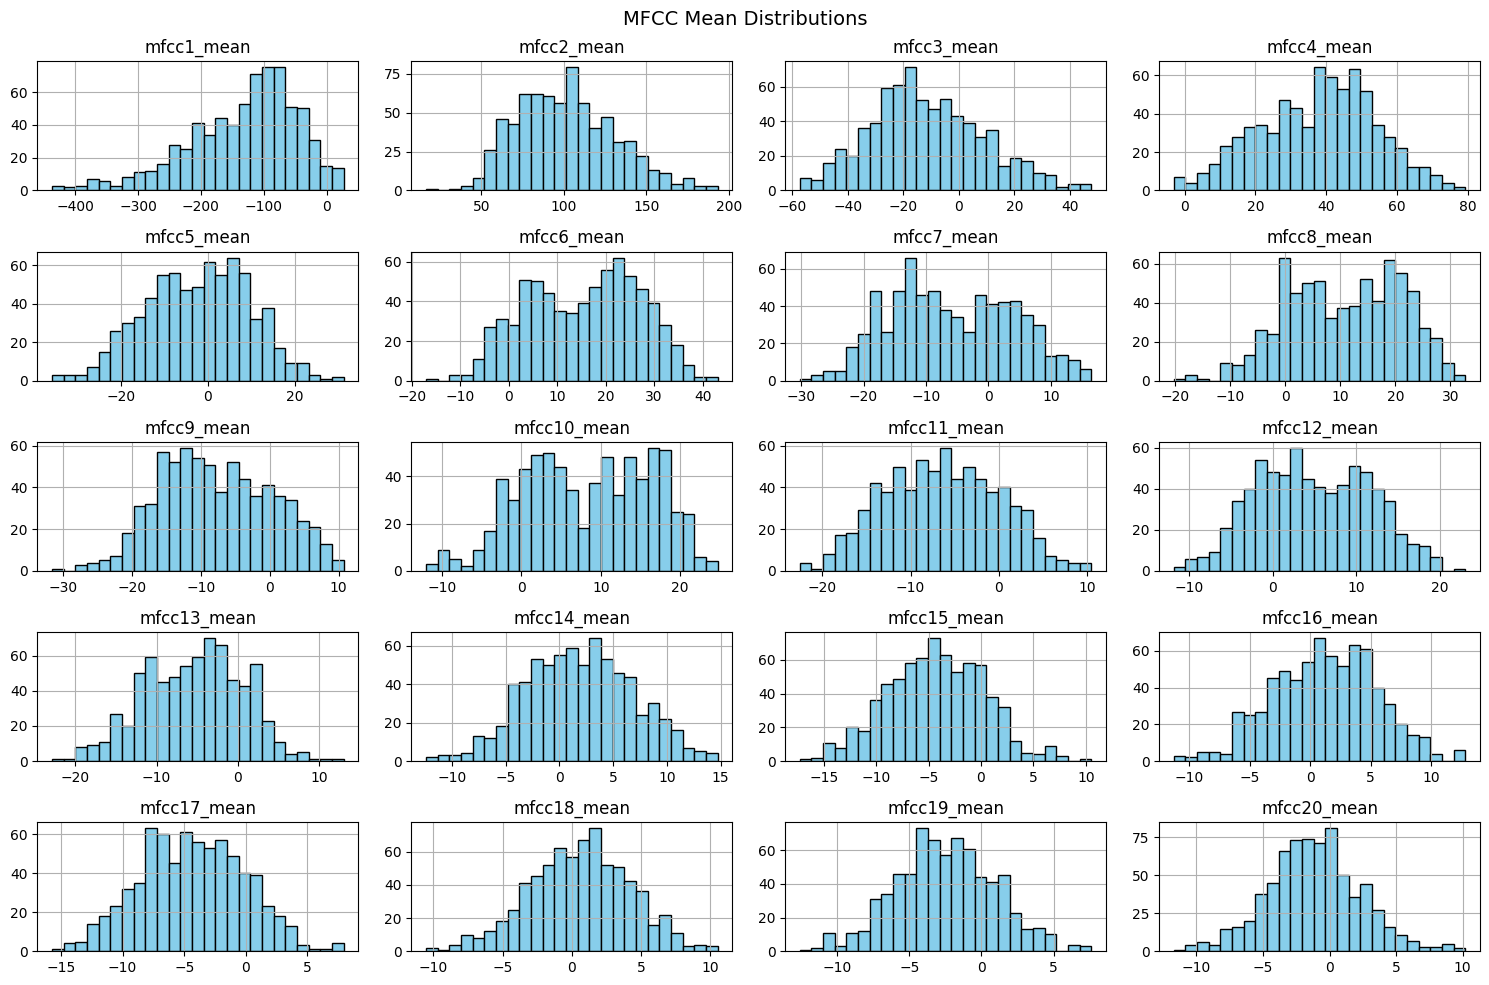

In [21]:
mfcc_mean_cols = [col for col in df_30_sec.columns if 'mfcc' in col and 'mean' in col]

df_30_sec[mfcc_mean_cols].hist(bins=25, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("MFCC Mean Distributions", fontsize=14)
plt.tight_layout()
plt.show()

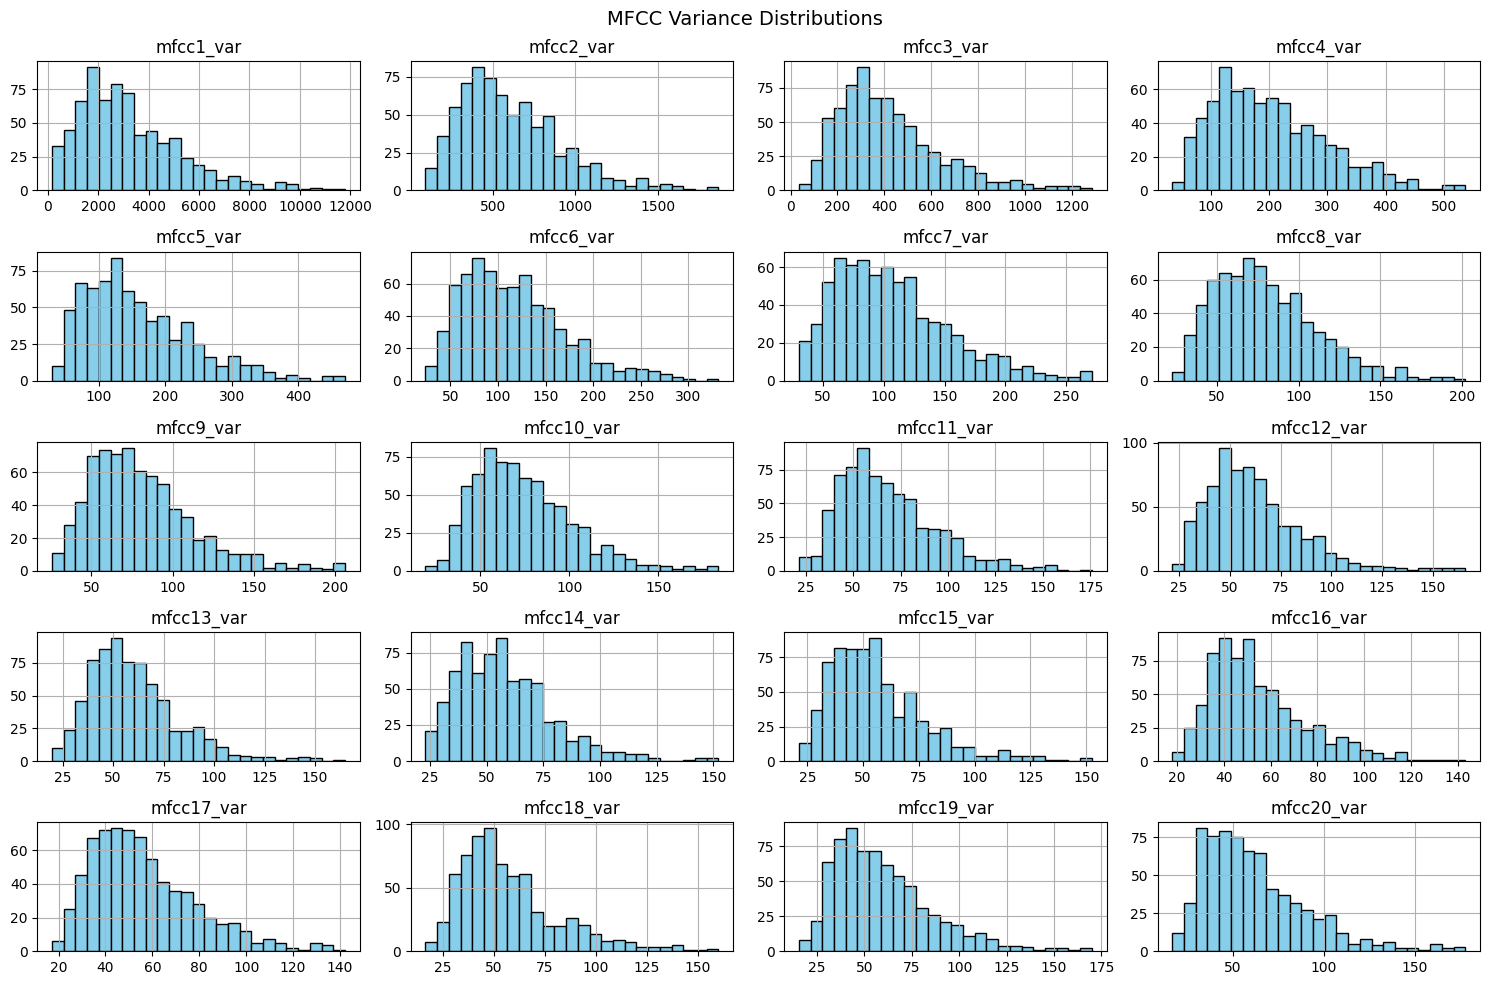

In [22]:
mfcc_var_cols = [col for col in df_30_sec.columns if 'mfcc' in col and 'var' in col]

df_30_sec[mfcc_var_cols].hist(bins=25, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("MFCC Variance Distributions", fontsize=14)
plt.tight_layout()
plt.show()

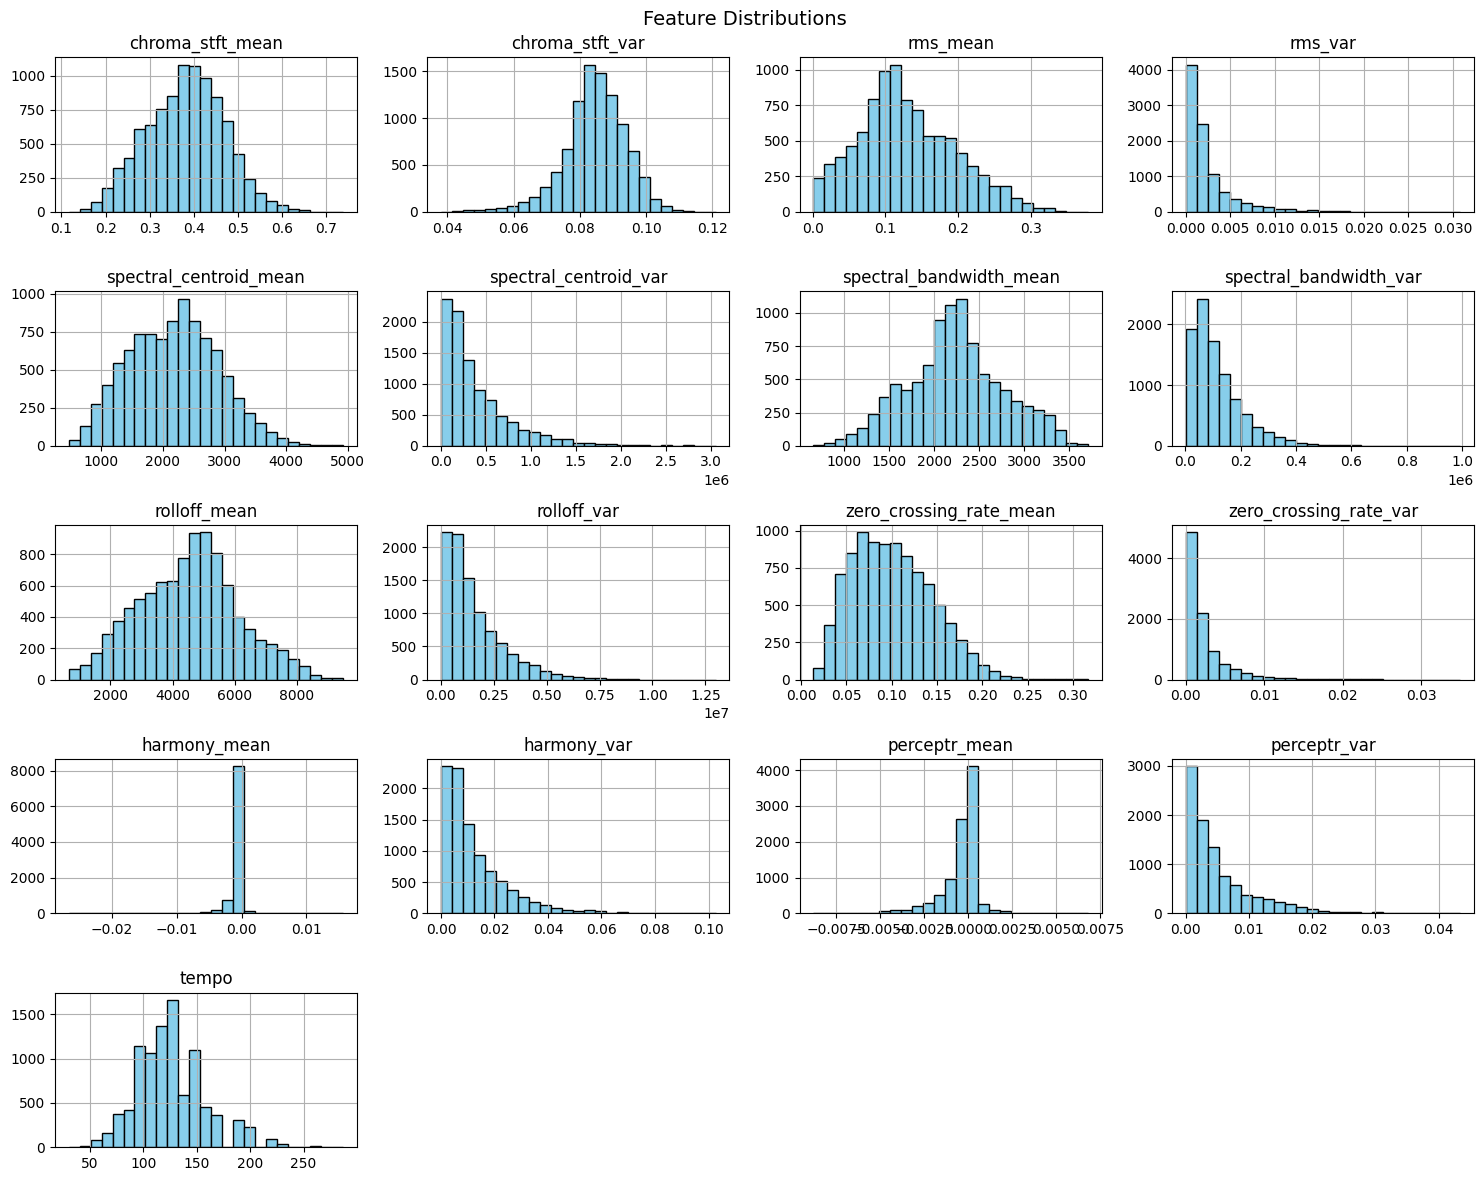

In [23]:
# Plot histogram of some features
filtered_features = [
    'chroma_stft_mean', 'chroma_stft_var',
    'rms_mean', 'rms_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'spectral_bandwidth_mean', 'spectral_bandwidth_var',
    'rolloff_mean', 'rolloff_var',
    'zero_crossing_rate_mean', 'zero_crossing_rate_var',
    'harmony_mean', 'harmony_var',
    'perceptr_mean', 'perceptr_var',
    'tempo']

df_3_sec[filtered_features].hist(bins=25, figsize=(15, 12), color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14)
plt.tight_layout()
plt.show()

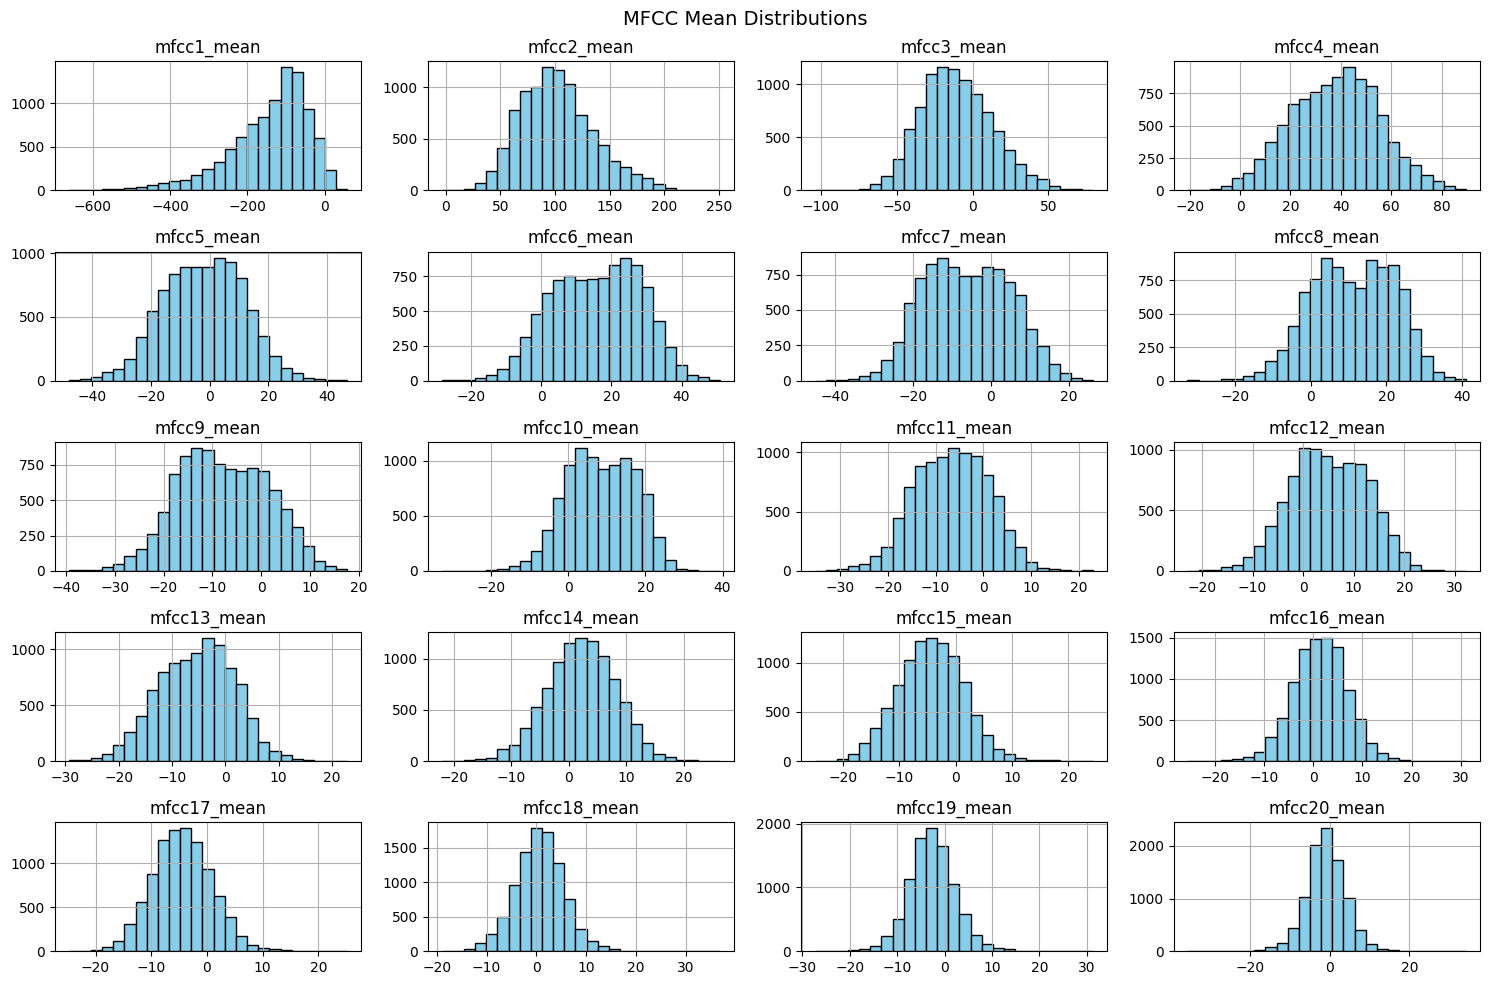

In [24]:
mfcc_mean_cols = [col for col in df_3_sec.columns if 'mfcc' in col and 'mean' in col]

df_3_sec[mfcc_mean_cols].hist(bins=25, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("MFCC Mean Distributions", fontsize=14)
plt.tight_layout()
plt.show()

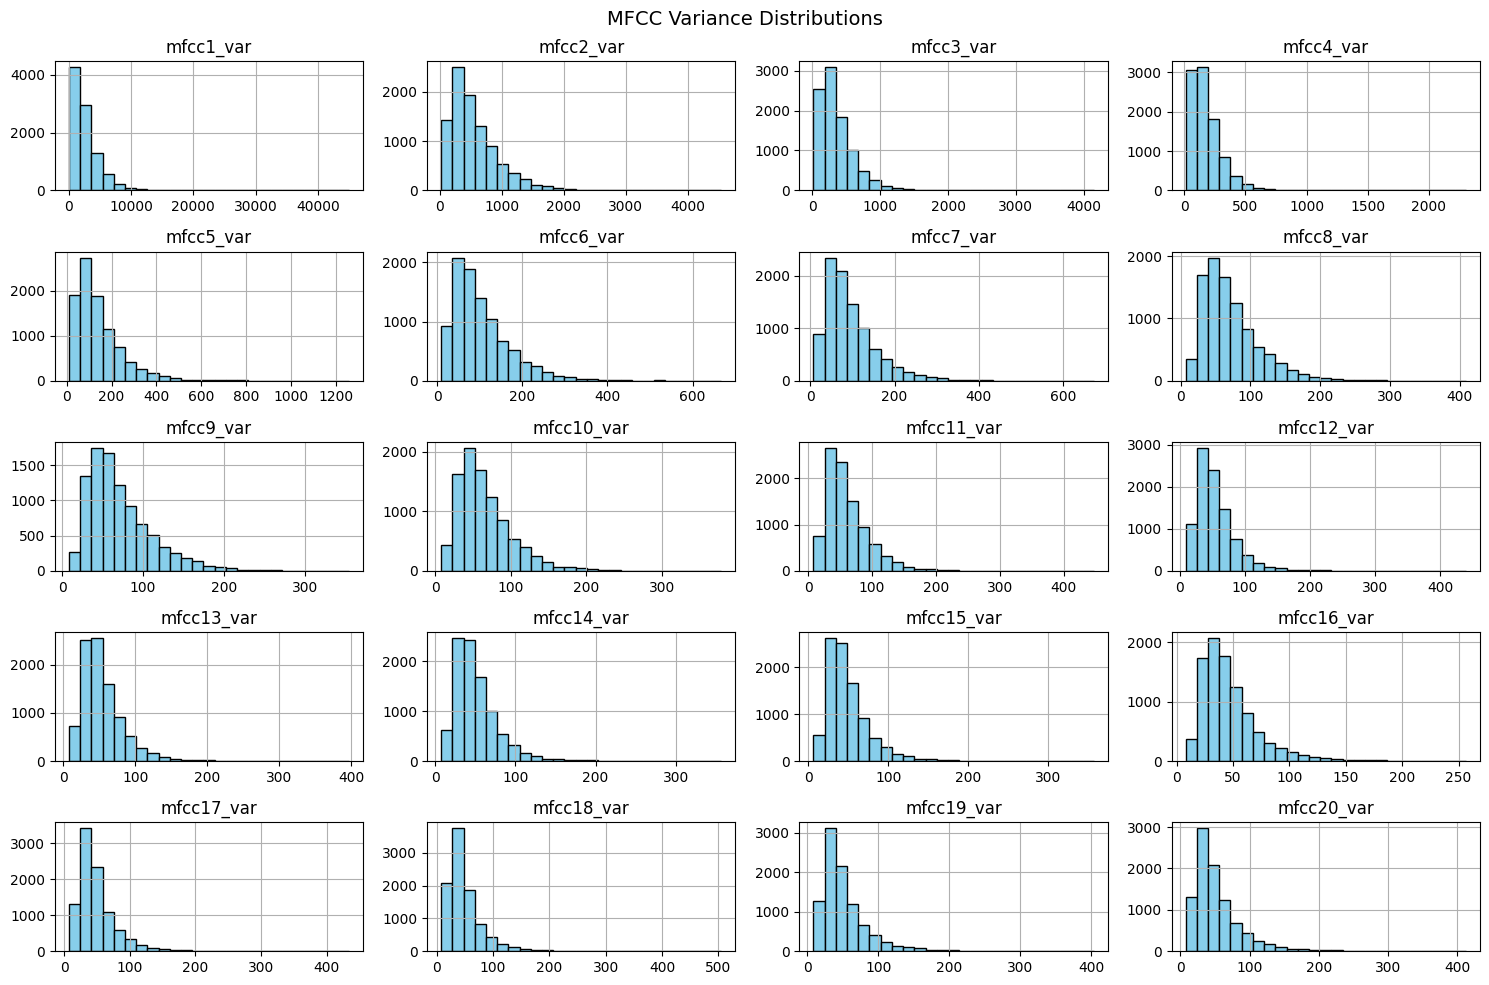

In [25]:
mfcc_var_cols = [col for col in df_3_sec.columns if 'mfcc' in col and 'var' in col]

df_3_sec[mfcc_var_cols].hist(bins=25, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("MFCC Variance Distributions", fontsize=14)
plt.tight_layout()
plt.show()

### Plot class distributions

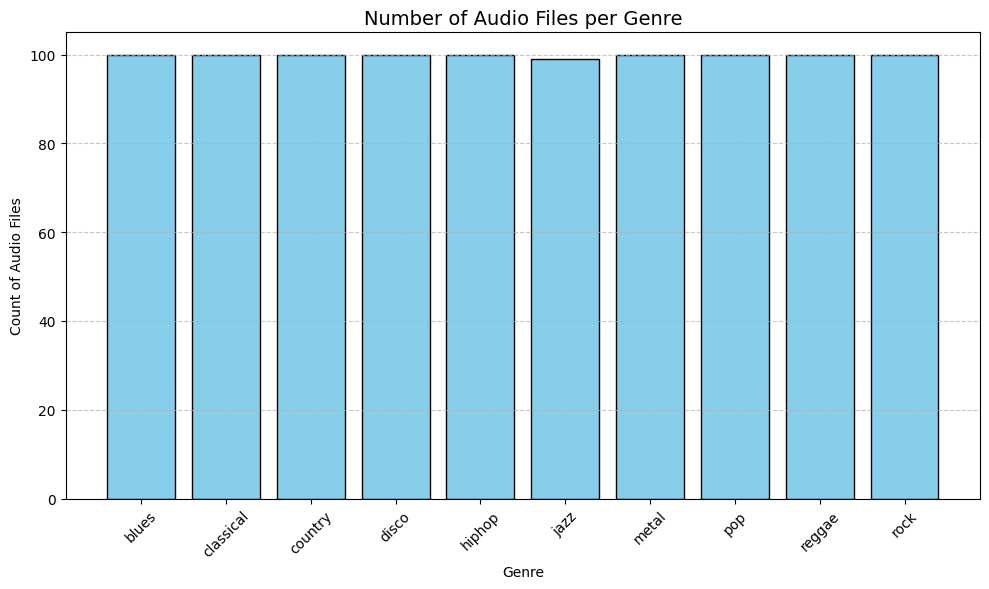

In [26]:
# Check the number of files inside each genre folder
genre_counts = {}

for genre in audio_files:
    genre_path = os.path.join(audio_dir, genre)
    if os.path.isdir(genre_path):
        num_files = len(os.listdir(genre_path))
        genre_counts[genre] = num_files

# Plot as bar chart
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.keys(), genre_counts.values(), color='skyblue', edgecolor='black')
plt.title("Number of Audio Files per Genre", fontsize=14)
plt.xlabel("Genre")
plt.ylabel("Count of Audio Files")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Class distribution for 30-second audio features:
label
rock         90
country      88
disco        85
metal        78
jazz         75
reggae       66
blues        65
pop          62
hiphop       55
classical    54
Name: count, dtype: int64


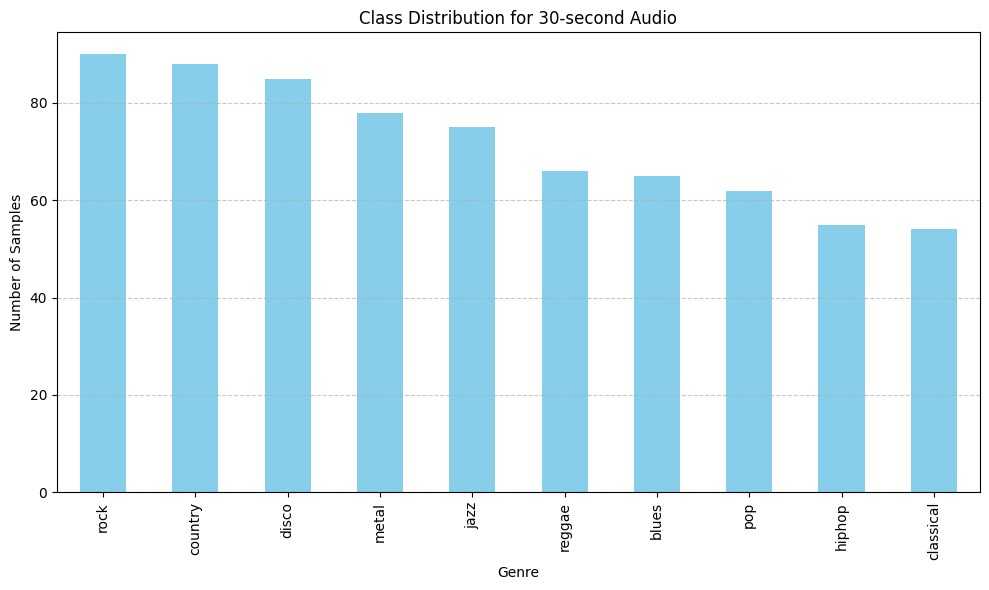

In [27]:
# Plot class distribution for 30-second audio features
if 'label' in df_30_sec.columns:
    genre_counts_30_sec = df_30_sec['label'].value_counts()
    print("\nClass distribution for 30-second audio features:")
    print(genre_counts_30_sec)
    genre_counts_30_sec.plot(kind='bar', figsize=(10, 6), color='skyblue')
    plt.title('Class Distribution for 30-second Audio')
    plt.xlabel('Genre')
    plt.ylabel('Number of Samples')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


Class distribution for 3-second audio features:
label
metal        993
country      992
disco        990
rock         989
blues        962
reggae       959
jazz         952
hiphop       920
classical    896
pop          837
Name: count, dtype: int64


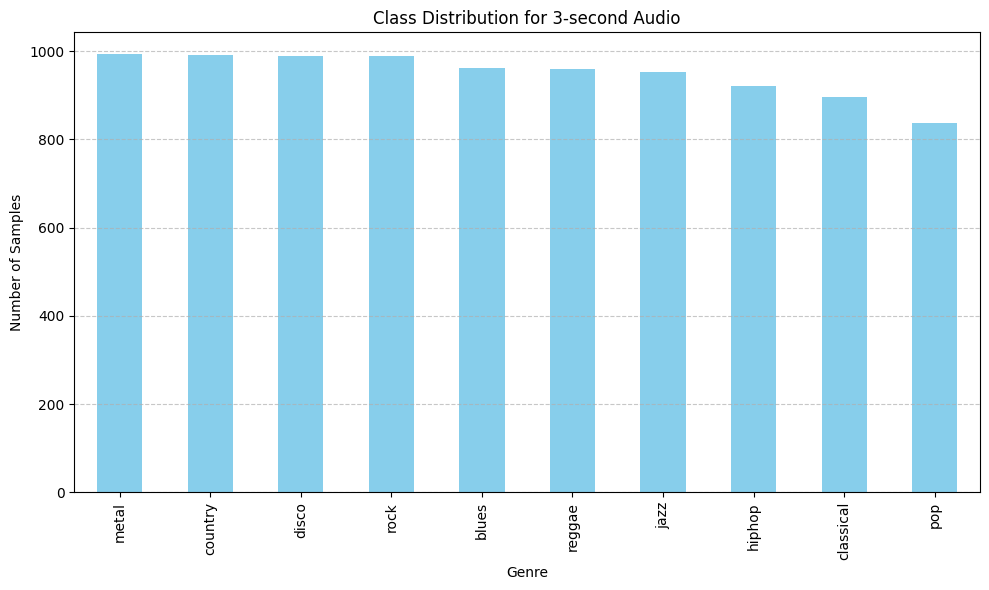

In [28]:
# Plot class distribution for 3-second audio features
if 'label' in df_3_sec.columns:
    genre_counts_3_sec = df_3_sec['label'].value_counts()
    print("\nClass distribution for 3-second audio features:")
    print(genre_counts_3_sec)

    genre_counts_3_sec.plot(kind='bar', figsize=(10, 6), color='skyblue')
    plt.title('Class Distribution for 3-second Audio')
    plt.xlabel('Genre')
    plt.ylabel('Number of Samples')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Feature distribution across genre

* Here, we are going to visualize the distribution of some important features across different genres. 
* For each plot, we’ll include brief observations on how genres differ in terms of that specific feature.

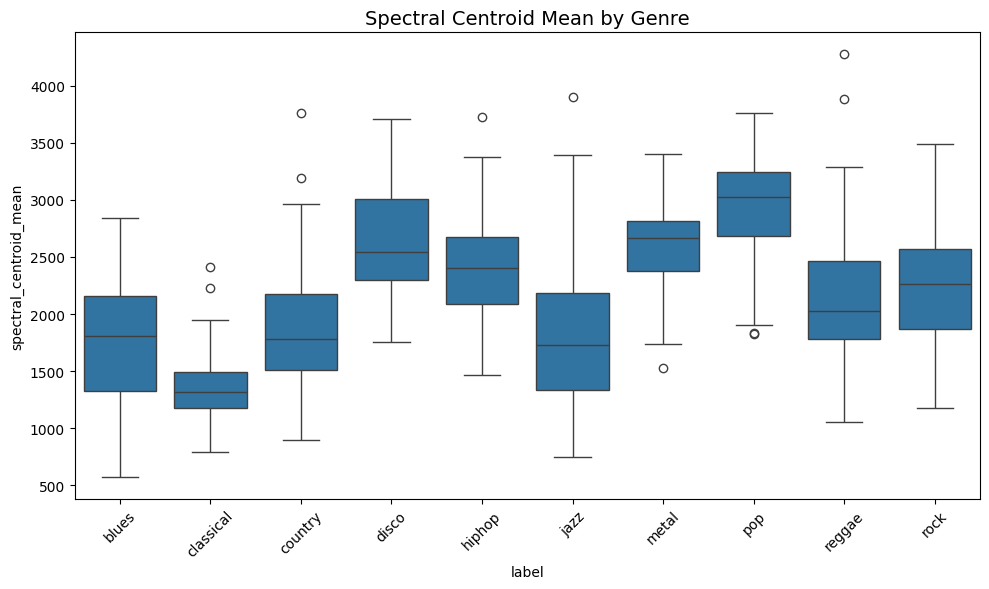

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='spectral_centroid_mean', data=df_30_sec)
plt.title("Spectral Centroid Mean by Genre", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation**
* As observed from the boxplots, genres like metal, pop, and disco tend to have higher `spectral_centroid_mean`. 
* This indicates that brighter or sharper sound characteristics. 
* Meanwhile, classical and jazz show lower centroids since these kind of songs have smoother and less percussive instrumentation.

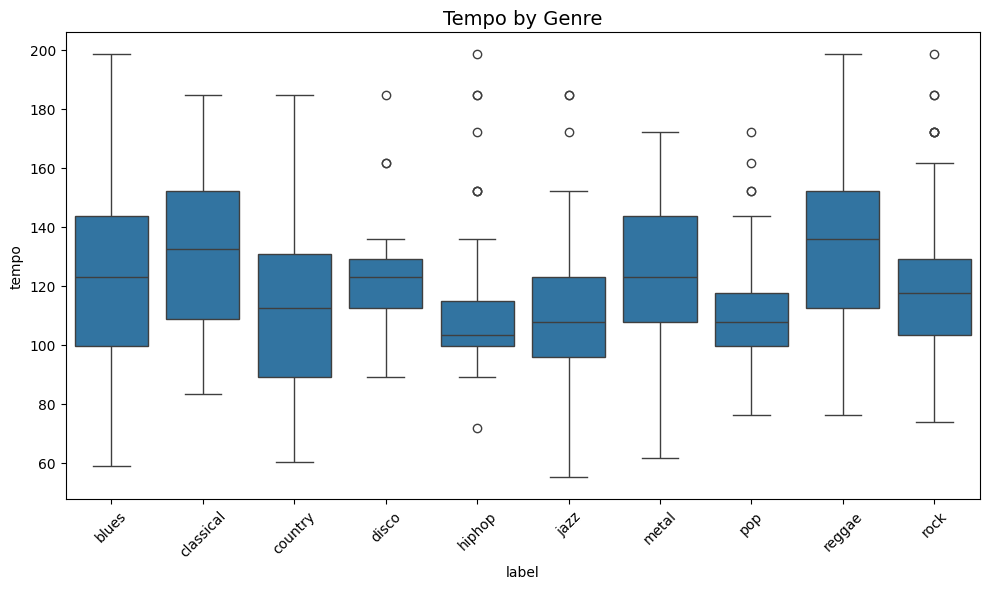

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='tempo', data=df_30_sec)
plt.title("Tempo by Genre", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation**
* For `tempo` variation, genres like blues, country, and reggae show the widest tempo distributions, with significant spread and outliers. 
* In contrast, disco, hiphop, and pop have compact tempo ranges. This suggest these genre have a consistent beat range.

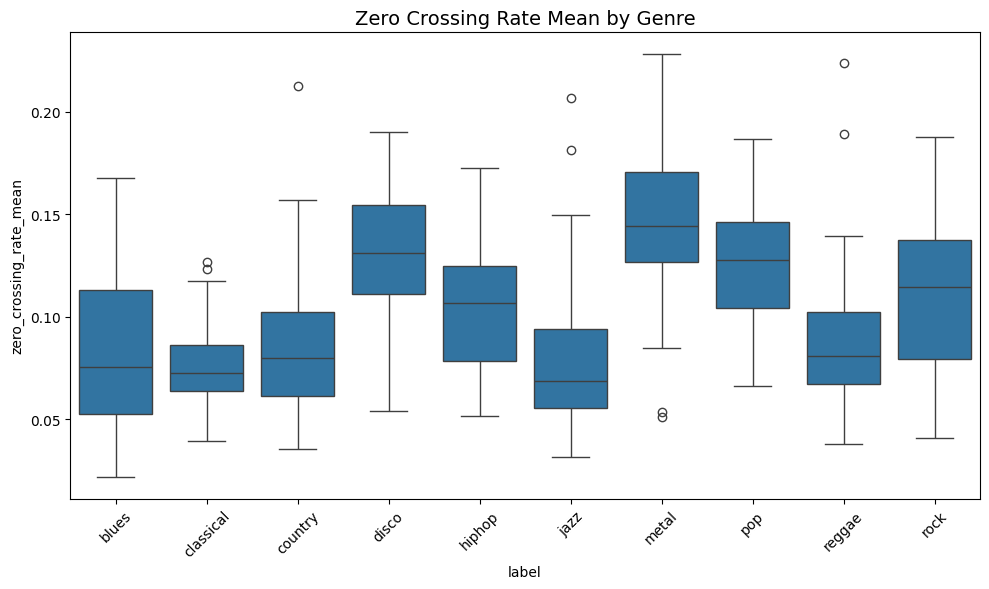

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='zero_crossing_rate_mean', data=df_30_sec)
plt.title("Zero Crossing Rate Mean by Genre", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation**
* This `zero_corssing_rate_mean` can indicate the noisiness or percussiveness in an audio. 
* Based on the boxplots, we can see that genres like metal, disco, and pop show higher zero crossing rates. This means they have more abrupt or noisy signal changes for punchy, distorted sounds. 
* Meanwhile, classica and jazz are much lower rates since they have smoother sounds. 

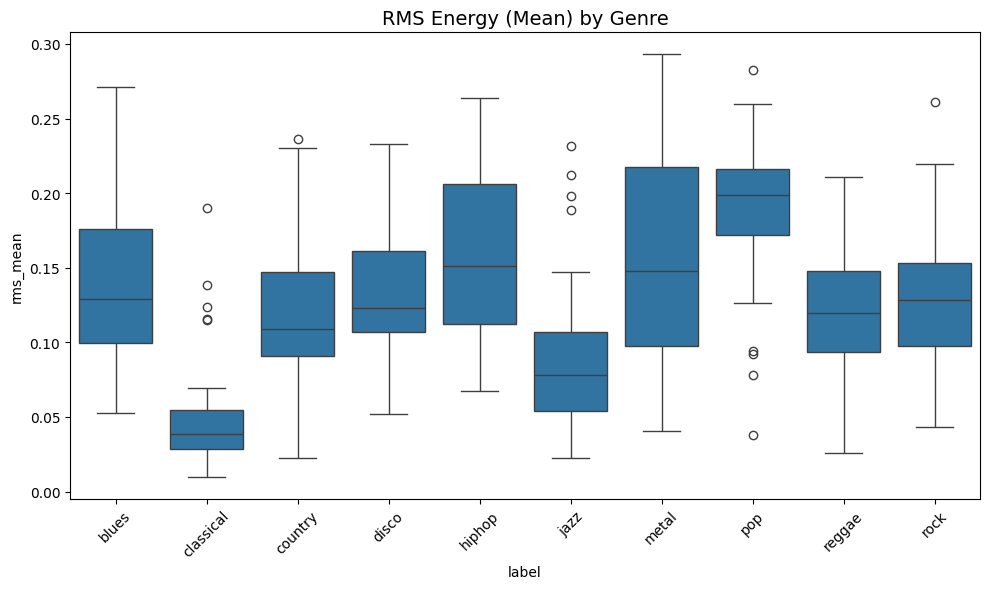

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='rms_mean', data=df_30_sec)
plt.title("RMS Energy (Mean) by Genre", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation**
* RMS energy can describe how loud or intense the audio signal is over time. 
* We visualized `rms_mean` across genres to compare their average energy levels.
* Based on the plot, we can see that metal and pop have highest RMS levels, whereas classical has the lowest RMS levels. 

### Check audio duration distribution

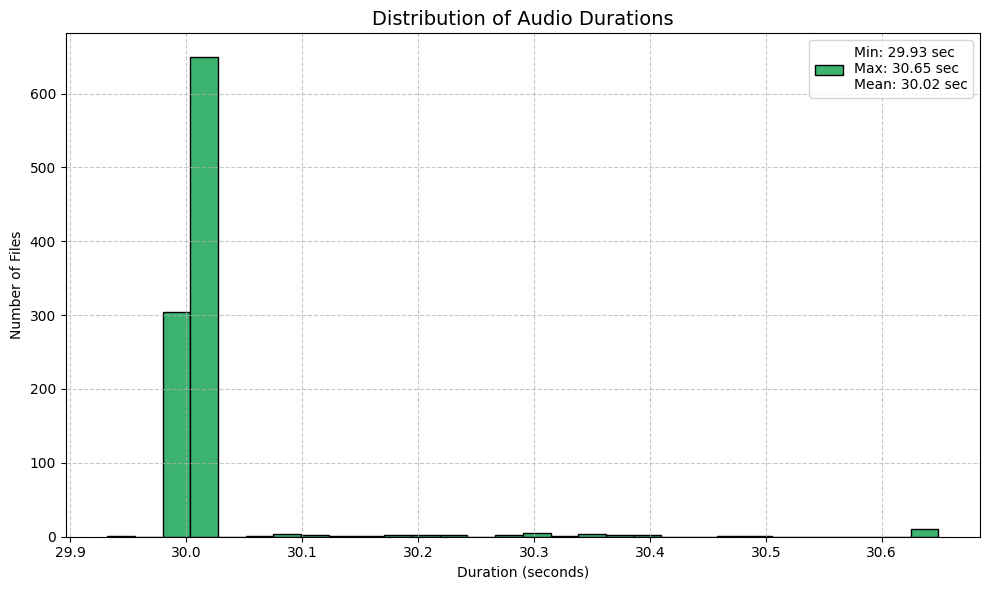

In [33]:
import librosa
import matplotlib.pyplot as plt

durations = []
for genre in audio_files:
    for file in os.listdir(os.path.join(audio_dir, genre)):
        if file.endswith('.wav'):
            y, sr = librosa.load(os.path.join(audio_dir, genre, file))
            durations.append(librosa.get_duration(y=y, sr=sr))

# Calculate stats
min_dur = np.min(durations)
max_dur = np.max(durations)
mean_dur = np.mean(durations)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=30, color='mediumseagreen', edgecolor='black')

# Add legend with stats
legend_text = (
    f"Min: {min_dur:.2f} sec\n"
    f"Max: {max_dur:.2f} sec\n"
    f"Mean: {mean_dur:.2f} sec"
)
plt.legend([legend_text], loc='upper right', fontsize=10)

plt.title("Distribution of Audio Durations", fontsize=14)
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Files")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Preview waveform and spectrogram

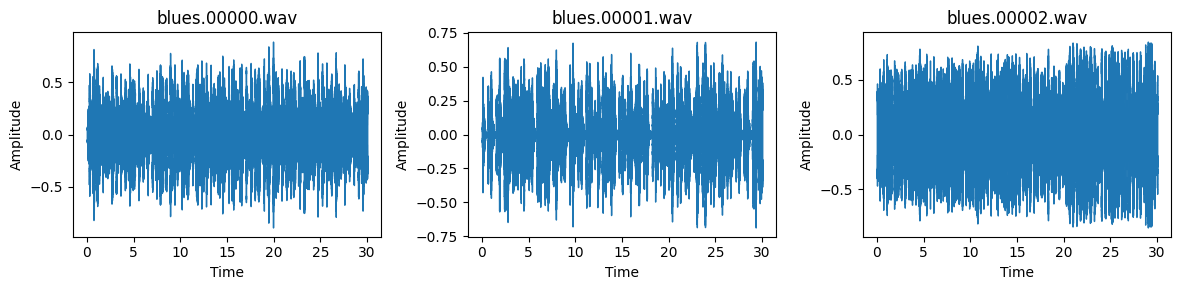

In [34]:
genre = 'blues'
file_paths = [os.path.join(audio_dir, genre, f) 
              for f in os.listdir(os.path.join(audio_dir, genre)) if f.endswith('.wav')][:3]

plt.figure(figsize=(12, 3))
for i, path in enumerate(file_paths):
    y, sr = librosa.load(path)
    plt.subplot(1, 3, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(os.path.basename(path))
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

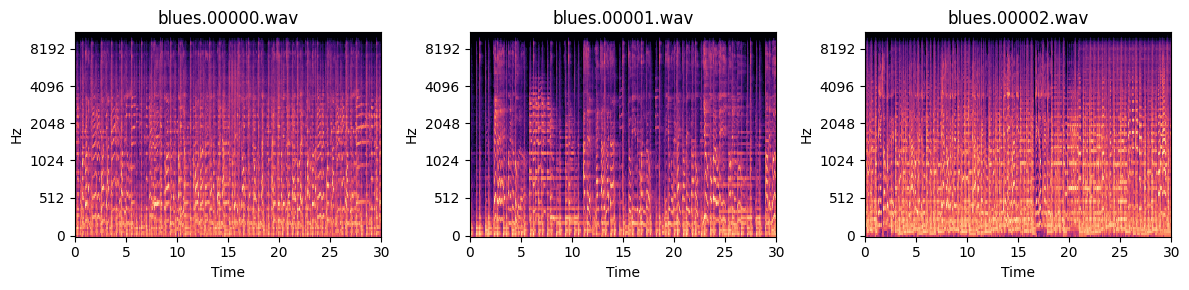

In [35]:
plt.figure(figsize=(12, 3))
for i, path in enumerate(file_paths):
    y, sr = librosa.load(path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.subplot(1, 3, i+1)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.title(os.path.basename(path))

plt.tight_layout()
plt.show()

## Feature Engineering

**Approach**
* To reduce redundancy, we analyzed the correlation matrix and removed features with strong multicollinearity (correlation > 0.95). 
* All remaining numerical features were standardized to ensure scale-invariance during training. 

### Plot correlation heatmap

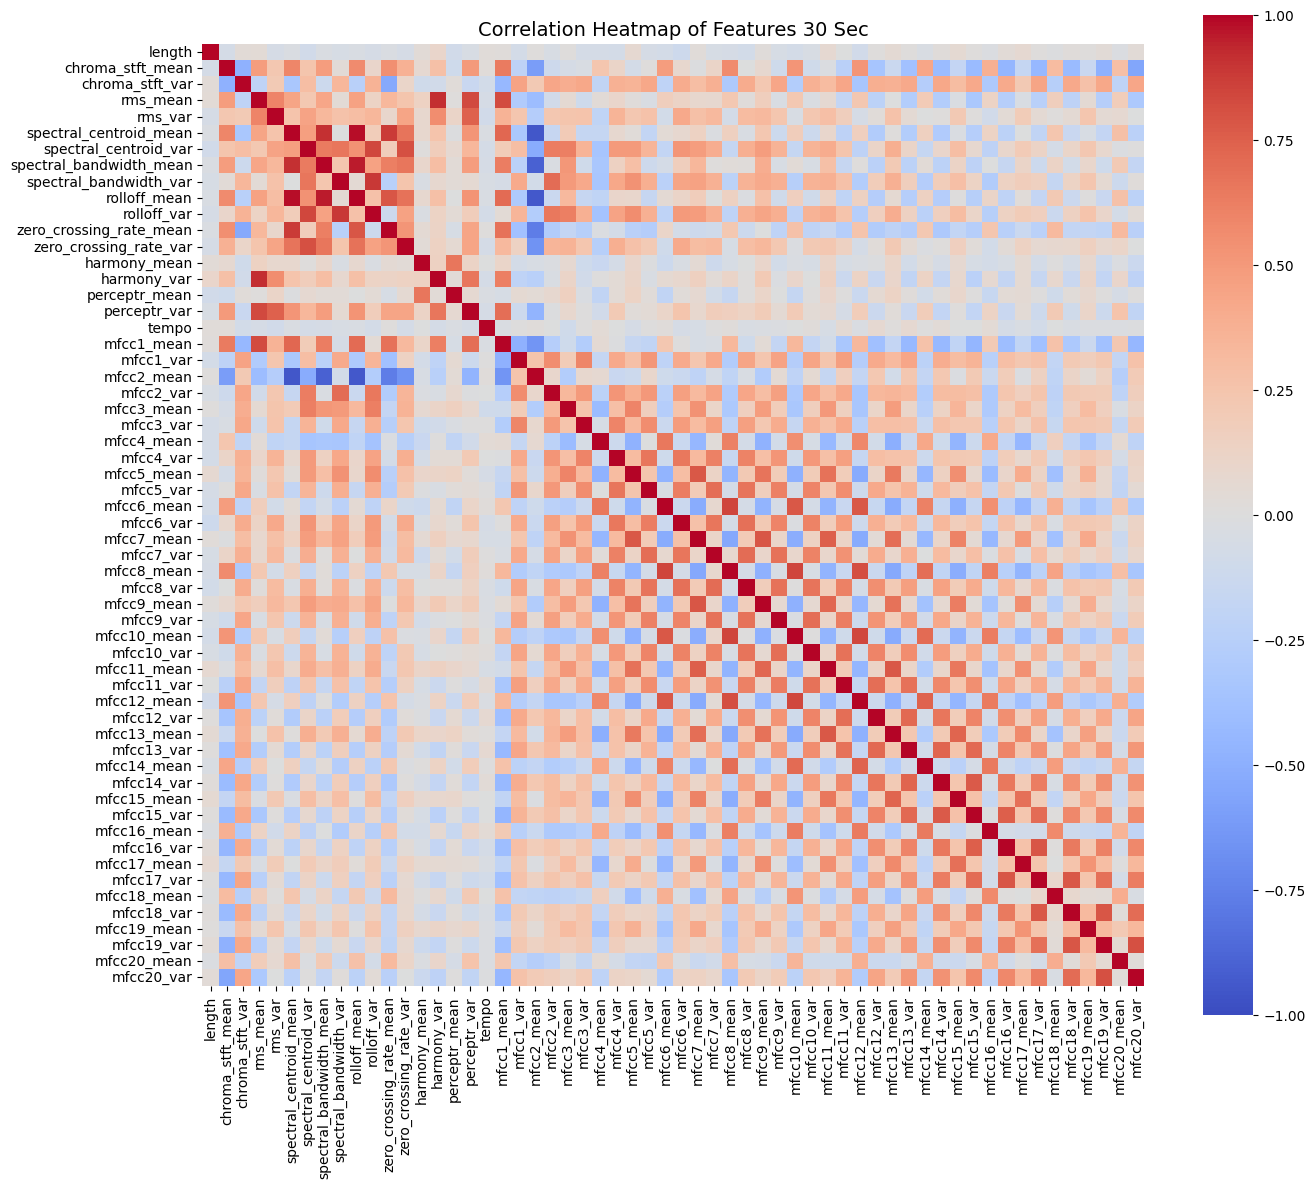

In [36]:
import numpy as np

# Drop unnecessary columns for correlation analysis
df_30_sec_cleaned = df_30_sec.drop(columns=['filename', 'label'])

# Get correlation matrix
corr_matrix_30s = df_30_sec_cleaned.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_30s, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt=".2f", square=True)
plt.title("Correlation Heatmap of Features 30 Sec", fontsize=14)
plt.tight_layout()
plt.show()

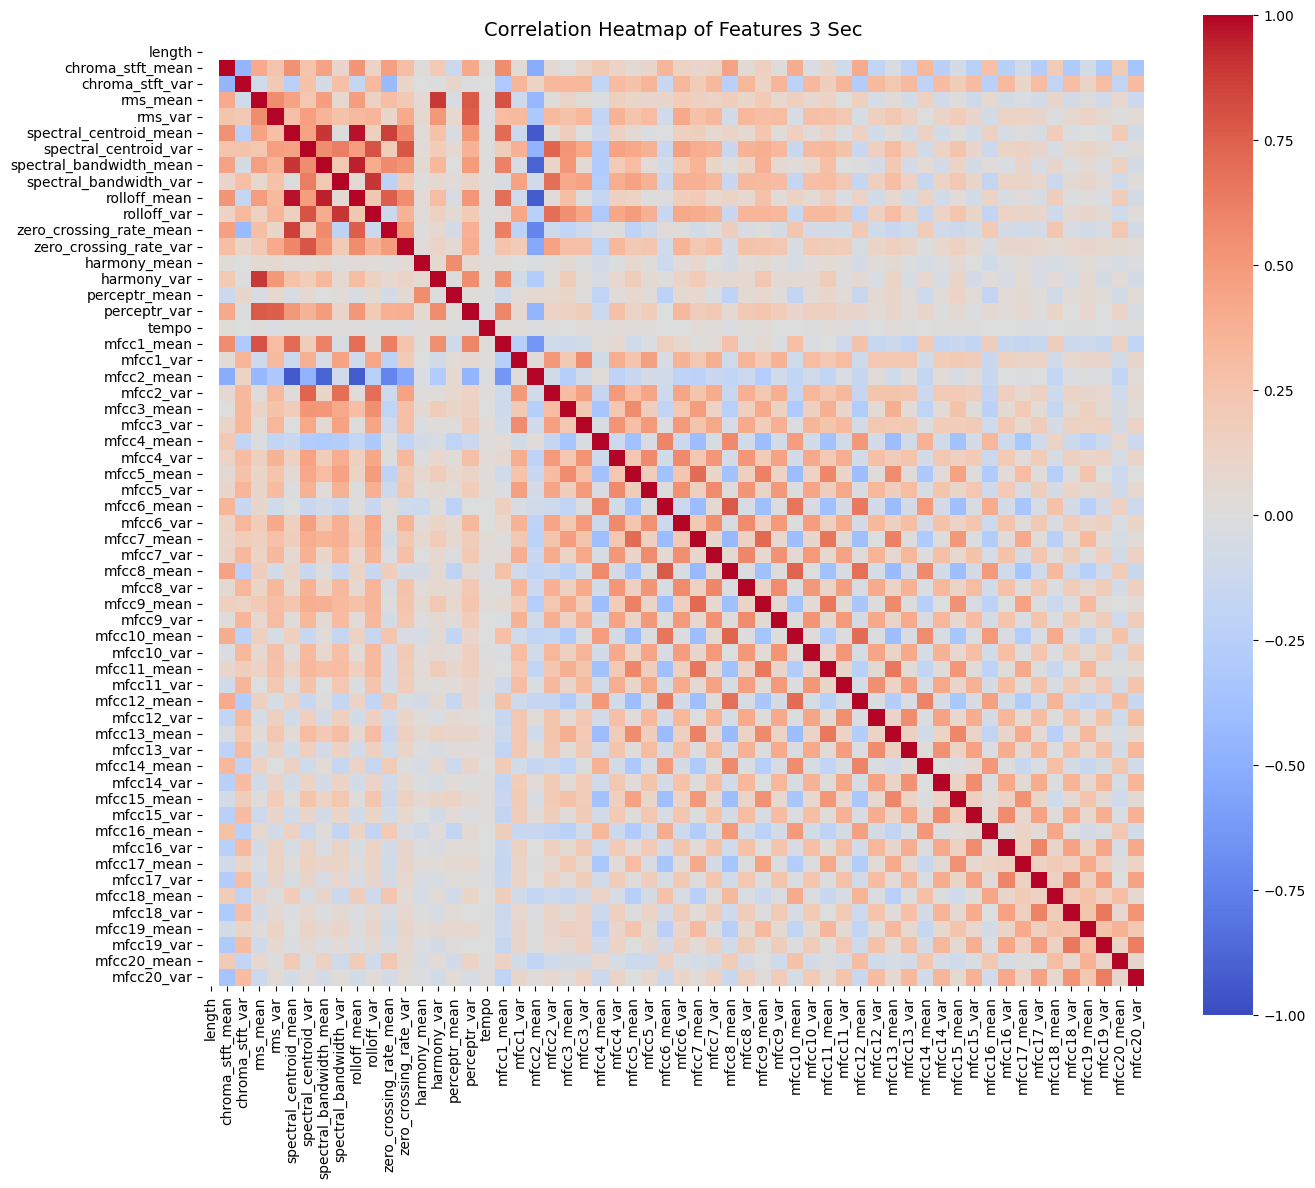

In [37]:
import numpy as np

# Drop unnecessary columns for correlation analysis
df_3_sec_cleaned = df_3_sec.drop(columns=['filename', 'label'])

# Get correlation matrix
corr_matrix_3s = df_3_sec_cleaned.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_3s, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt=".2f", square=True)
plt.title("Correlation Heatmap of Features 3 Sec", fontsize=14)
plt.tight_layout()
plt.show()

### Remove highly correlated features

In [38]:
# Select upper triangle of correlation matrix
upper = corr_matrix_30s.where(np.triu(np.ones(corr_matrix_30s.shape), k=1).astype(bool))

# Flatten and filter high correlations
high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0: 'Correlation'})
)

# Show only pairs with correlation >= 0.95
high_corr_filtered = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.95]\
                        .sort_values(by='Correlation', ascending=False)

# Display
print(high_corr_filtered)

                   Feature_1     Feature_2  Correlation
278   spectral_centroid_mean  rolloff_mean     0.979605
379  spectral_bandwidth_mean  rolloff_mean     0.957395


In [39]:
# Check corr_matrix of rollroll_var
corr_matrix_30s['rolloff_var'].sort_values(ascending=False).head(10)

rolloff_var                1.000000
spectral_bandwidth_var     0.887500
spectral_centroid_var      0.836932
mfcc2_var                  0.650910
mfcc3_mean                 0.624300
mfcc5_mean                 0.556190
mfcc6_var                  0.499987
mfcc7_mean                 0.486511
spectral_bandwidth_mean    0.455763
zero_crossing_rate_var     0.455691
Name: rolloff_var, dtype: float64

In [40]:
# Select upper triangle of correlation matrix
upper = corr_matrix_3s.where(np.triu(np.ones(corr_matrix_3s.shape), k=1).astype(bool))

# Flatten and filter high correlations
high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0: 'Correlation'})
)

# Show only pairs with correlation >= 0.95
high_corr_filtered = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.95]\
                        .sort_values(by='Correlation', ascending=False)

# Display
print(high_corr_filtered)

                   Feature_1     Feature_2  Correlation
221   spectral_centroid_mean  rolloff_mean     0.975213
322  spectral_bandwidth_mean  rolloff_mean     0.950094


In [41]:
# Check corr_matrix of rollroll_var
corr_matrix_3s['rolloff_var'].sort_values(ascending=False).head(10)

rolloff_var               1.000000
spectral_bandwidth_var    0.892426
spectral_centroid_var     0.791734
mfcc2_var                 0.693367
mfcc3_mean                0.550718
mfcc5_mean                0.489994
mfcc3_var                 0.442847
mfcc1_var                 0.436033
mfcc6_var                 0.425873
mfcc4_var                 0.424112
Name: rolloff_var, dtype: float64

In [42]:
# Drop rolloff_mean from df_30_sec_cleaned
df_30_sec_cleaned.drop(columns=['rolloff_mean'], inplace=True)

In [43]:
# Drop rolloff_mean from df_3_sec_cleaned
df_3_sec_cleaned.drop(columns=['rolloff_mean'], inplace=True)

**Observation**
* Based on correlation analysis, `rolloff_mean` was highly correlated with both `spectral_centroid_mean` and `spectral_bandwidth_mean` in both df_30_sec and df_3_sec features. 
* To reduce multicollinearity, we removed `rolloff_mean` but retain the rest of the features since they don't show high correlation with each other. 

In [44]:
# Check correlation between mfcc features
mfcc_mean_cols = [col for col in df_30_sec_cleaned.columns if 'mfcc' in col and 'mean' in col]
mfcc_corr = df_30_sec[mfcc_mean_cols].corr().abs()

upper = mfcc_corr.where(np.triu(np.ones(mfcc_corr.shape), k=1).astype(bool))

top_mfcc_corr = (
    upper.stack()
    .reset_index()
    .rename(columns={'level_0': 'MFCC_1', 'level_1': 'MFCC_2', 0: 'Correlation'})
    .sort_values(by='Correlation', ascending=False)
)

print(top_mfcc_corr.head(10))

          MFCC_1       MFCC_2  Correlation
86    mfcc6_mean   mfcc8_mean     0.851004
113   mfcc8_mean  mfcc10_mean     0.848698
136  mfcc10_mean  mfcc12_mean     0.836437
115   mfcc8_mean  mfcc12_mean     0.815958
100   mfcc7_mean   mfcc9_mean     0.782710
71    mfcc5_mean   mfcc7_mean     0.780664
90    mfcc6_mean  mfcc12_mean     0.779217
88    mfcc6_mean  mfcc10_mean     0.774380
146  mfcc11_mean  mfcc13_mean     0.773815
102   mfcc7_mean  mfcc11_mean     0.756356


In [45]:
mfcc_var_cols = [col for col in df_30_sec_cleaned.columns if 'mfcc' in col and 'var' in col]
mfcc_var_corr = df_30_sec[mfcc_var_cols].corr().abs()

upper_var = mfcc_var_corr.where(np.triu(np.ones(mfcc_var_corr.shape), k=1).astype(bool))

top_var_corr = (
    upper_var.stack()
    .reset_index()
    .rename(columns={'level_0': 'MFCC_1', 'level_1': 'MFCC_2', 0: 'Correlation'})
    .sort_values(by='Correlation', ascending=False)
)

print(top_var_corr.head(10))

         MFCC_1      MFCC_2  Correlation
189  mfcc19_var  mfcc20_var     0.812138
187  mfcc18_var  mfcc19_var     0.786457
180  mfcc16_var  mfcc17_var     0.783574
184  mfcc17_var  mfcc18_var     0.780261
169  mfcc14_var  mfcc15_var     0.765938
175  mfcc15_var  mfcc16_var     0.752691
162  mfcc13_var  mfcc14_var     0.732313
163  mfcc13_var  mfcc15_var     0.714060
154  mfcc12_var  mfcc13_var     0.712768
99    mfcc7_var   mfcc8_var     0.696476


**Observation**
* MFCC mean and var features showed moderate correlation (max ~0.85 and ~0.81), especially among neighboring coefficients (e.g. mfcc19 & mfcc20, mfcc18 & mfcc18, etc.)
* However, no pair exceeded the 0.95 threshold, so we decided to retain all MFCC features. 

In [46]:
# Print the shape of original dataframes
print(f"Original 30-sec features shape: {df_30_sec.shape}")
print(f"Original 3-sec features shape: {df_3_sec.shape}")

# Add the label column back to the cleaned dataframes
df_30_sec_cleaned['label'] = df_30_sec['label']
df_3_sec_cleaned['label'] = df_3_sec['label']

# Add the filename column back to the cleaned dataframes for tracking purposes
df_30_sec_cleaned['filename'] = df_30_sec['filename']
df_3_sec_cleaned['filename'] = df_3_sec['filename']

# Verify the shape of the cleaned dataframes
print(f"Cleaned 30-sec features shape: {df_30_sec_cleaned.shape}")
print(f"Cleaned 3-sec features shape: {df_3_sec_cleaned.shape}")

Original 30-sec features shape: (718, 60)
Original 3-sec features shape: (9490, 60)
Cleaned 30-sec features shape: (718, 59)
Cleaned 3-sec features shape: (9490, 59)


Note: Since we removed rolloff_mean column column, we have 60-1 = 60 columns now. 

### Normalize or standardize features

In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
# -----------------------------------
# FUNCTION: Process any dataset
# -----------------------------------
def feature_engineering(df):
    df_encoded = df.copy()

    # Step 1: Label Encode the 'label' column
    le = LabelEncoder()
    df_encoded['label_encoded'] = le.fit_transform(df_encoded['label'])

    # Step 2: Extract only numeric columns (excluding label_encoded)
    numeric_df = df_encoded.select_dtypes(include='number').drop(columns=['label_encoded']).copy()

    # Step 3: Create statistical features
    numeric_df['mean_feature'] = numeric_df.mean(axis=1)
    numeric_df['std_feature'] = numeric_df.std(axis=1)
    numeric_df['max_feature'] = numeric_df.max(axis=1)
    numeric_df['min_feature'] = numeric_df.min(axis=1)
    numeric_df['range_feature'] = numeric_df['max_feature'] - numeric_df['min_feature']

    # Step 4: Normalize all numeric features
    scaler = StandardScaler()
    numeric_scaled = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)

    # Step 5: Combine with non-numeric columns (like filename, label, label_encoded)
    non_numeric_df = df_encoded[['filename', 'label', 'label_encoded']]
    final_df = pd.concat([non_numeric_df.reset_index(drop=True), numeric_scaled.reset_index(drop=True)], axis=1)

    return final_df

# -----------------------------------
# Apply the function to both datasets
# -----------------------------------
final_df_3 = feature_engineering(df_3_sec_cleaned)
final_df_30 = feature_engineering(df_30_sec_cleaned)

# -----------------------------------
# View sample outputs
# -----------------------------------
print("3-sec Dataset:")
print(final_df_3.head(), "\n")
print("30-sec Dataset:")
print(final_df_30.head(), "\n")


3-sec Dataset:
            filename  label  label_encoded  length  chroma_stft_mean  \
0  blues.00000.0.wav  blues              0     0.0         -0.527487   
1  blues.00000.1.wav  blues              0     0.0         -0.440308   
2  blues.00000.2.wav  blues              0     0.0         -0.397630   
3  blues.00000.3.wav  blues              0     0.0         -0.206129   
4  blues.00000.4.wav  blues              0     0.0         -0.525517   

   chroma_stft_var  rms_mean   rms_var  spectral_centroid_mean  \
0         0.691530  0.005818  0.352738               -0.561835   
1         0.168942 -0.261275 -0.326710               -0.501554   
2         0.818888  0.029929  0.713370               -0.540454   
3         0.244598  0.038397  0.000621               -0.724565   
4         0.380249  0.200171 -0.244310               -0.758600   

   spectral_centroid_var  ...  mfcc18_var  mfcc19_mean  mfcc19_var  \
0              -0.580855  ...   -0.352601    -0.493998   -0.538671   
1              

In [48]:
# Verify the shape of the final datasets
print(f"Final 30-sec features shape: {final_df_30.shape}")
print(f"Final 3-sec features shape: {final_df_3.shape}")

Final 30-sec features shape: (718, 65)
Final 3-sec features shape: (9490, 65)


### (TO DO) Perform feature selection for ML models

### Split audio files into Train, Validation and Test sets

**Approach**
* First, we split the original audio files into three sets — 70% for training, 15% for validation, and 15% for testing.
* All files are saved under a new directory: `Dataset/genres_split/`, organized by split and genre.
* We built a function called `split_audio_dataset()` in `split_audio_dataset.py`. This function takes a folder of folder of genre-labeled audio files, and distributes them into train, val, or test subfolders based on the specified split ratios.
* After splitting, we used `process_spectrogram_split()` function from `generate_spectogram_images.py` file. This function will convert each audio file under train, val, and test subfolders into Mel Spectrogram images using `librosa`. 
* We decided to generate our own images instead of using the original spectorgram images since those were generated before cleaning and splitting. 
* This way, the images are fully aligned with the cleaned and correctly split audio files.

In [49]:
from pathlib import Path

# Define the path to the spectrograms generated from the split audio files
audio_root = Path.cwd() / "Dataset" / "genres_split"

# Count PNG files for each subfolder
train_count = sum(len(list((audio_root / 'train' / genre).glob("*.wav"))) 
                  for genre in (audio_root / 'train').iterdir() if genre.is_dir())

val_count = sum(len(list((audio_root / 'val' / genre).glob("*.wav"))) 
                for genre in (audio_root / 'val').iterdir() if genre.is_dir())

test_count = sum(len(list((audio_root / 'test' / genre).glob("*.wav"))) 
                 for genre in (audio_root / 'test').iterdir() if genre.is_dir())

# Print the results
print(f"Train set: {train_count}")
print(f"Validation set: {val_count}")
print(f"Test set: {test_count}")

Train set: 892
Validation set: 269
Test set: 271


In [50]:
from pathlib import Path

# Define the path to the spectrograms generated from the split audio files
image_root = Path.cwd() / "Dataset" / "spectrograms_split"

# Count PNG files for each subfolder
train_count = sum(len(list((image_root / 'train' / genre).glob("*.png"))) 
                  for genre in (image_root / 'train').iterdir() if genre.is_dir())

val_count = sum(len(list((image_root / 'val' / genre).glob("*.png"))) 
                for genre in (image_root / 'val').iterdir() if genre.is_dir())

test_count = sum(len(list((image_root / 'test' / genre).glob("*.png"))) 
                 for genre in (image_root / 'test').iterdir() if genre.is_dir())

# Print the results
print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

Train images: 892
Validation images: 269
Test images: 271


In [51]:
# Check the class distribution in the training set
train_path = Path("Dataset/spectrograms_split/train")

for genre_dir in train_path.iterdir():
    if genre_dir.is_dir():
        count = len(list(genre_dir.glob("*.png")))
        print(f"{genre_dir.name}: {count}")

blues: 88
classical: 88
country: 89
disco: 92
hiphop: 90
jazz: 88
metal: 90
pop: 86
reggae: 93
rock: 88


### Preprocess generated images

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Constants
IMG_WIDTH = 400
IMG_HEIGHT = 300 # Adjust based on spectrogram size
BATCH_SIZE = 32

# Set correct path
DATASET_PATH = 'Dataset/spectrograms_split'

# Generate training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,         # slight rotation as music spectrograms tolerate this
    width_shift_range=0.1,     # horizontal shift
    height_shift_range=0.1,    # vertical shift
    zoom_range=0.1,            # zoom in/out
    horizontal_flip=False,     # don't flip spectrograms
    fill_mode='nearest'        # fill empty pixels
)

# Generate validation and test without augmentation and only rescaling to [0, 1]
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Define train generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Define validation generator
val_generator = test_val_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'val'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Define test generator
test_generator = test_val_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 892 images belonging to 10 classes.
Found 269 images belonging to 10 classes.
Found 271 images belonging to 10 classes.


In [84]:
import pickle

# Get class indices
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Save to file for use in the Streamlit app
with open("models/class_indices.pkl", "wb") as f:
    pickle.dump(class_indices, f)

Class indices: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Class-to-Index Mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
Image Shape: (300, 400, 3)


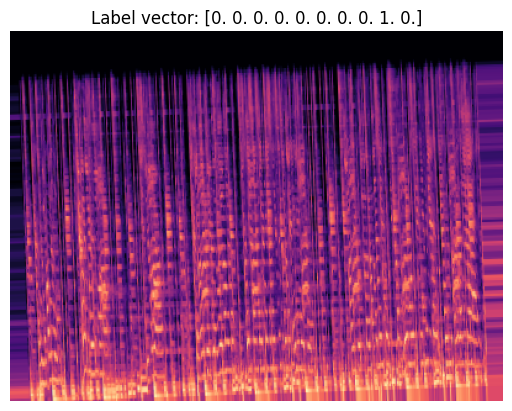

In [ ]:
# Check the class indices and image shape
print("Class-to-Index Mapping:", train_generator.class_indices)
print("Image Shape:", train_generator.image_shape)

# Visualize a sample image
x_batch, y_batch = next(train_generator)
plt.imshow(x_batch[0])
plt.title(f"Label vector: {y_batch[0]}")
plt.axis('off')
plt.show()

## Model Building

### Create a baseline CNN model

We built a simple CNN model to classify music genres from spectrogram images:
* We start with an input layer that takes in 128x128 RGB images.
* Then, we add 3 convolutional layers, each followed by max pooling to reduce the image size while keeping important features.
* After flattening the output, we use a dropout layer to reduce overfitting.
* We connect it to a dense layer with 128 neurons, followed by a softmax output layer with 10 units — one for each genre.
* Finally, we compile the model using Adam optimizer (with a learning rate of 0.0001), categorical crossentropy as the loss function, and track accuracy as our metric.

In [63]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a baseline CNN model
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 298, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 149, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 147, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 73, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 71, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 35, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 215040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 215040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    27,525,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,619,786 (105.36 MB)

 Trainable params: 27,619,786 (105.36 MB)

 Non-trainable params: 0 (0.00 B)

### Handle class imbalance using class_weight

In [64]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get the class labels from the training generator
labels = train_generator.classes

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

### Define early stopping and model checkpoint

In [69]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
os.makedirs("models", exist_ok=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'cnn_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

callbacks = [early_stopping, model_checkpoint]

### Train the baseline CNN model

In [70]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.5055 - loss: 1.4375 - val_accuracy: 0.5985 - val_loss: 1.2511
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5462 - loss: 1.3082 - val_accuracy: 0.4461 - val_loss: 1.4096
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.5029 - loss: 1.3855 - val_accuracy: 0.6022 - val_loss: 1.1800
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5503 - loss: 1.3666 - val_accuracy: 0.5465 - val_loss: 1.1634
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.5643 - loss: 1.2132 - val_accuracy: 0.5613 - val_loss: 1.2099
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.5669 - loss: 1.2272 - val_accuracy: 0.5316 - val_loss: 1.3292
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5432 - loss: 1.2821 - val_accuracy: 0.5799 - val_loss: 1.2294
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.5606 - loss: 1.2557 - val_accuracy: 0.5651 - val_loss

### Plot accuracy and loss curves

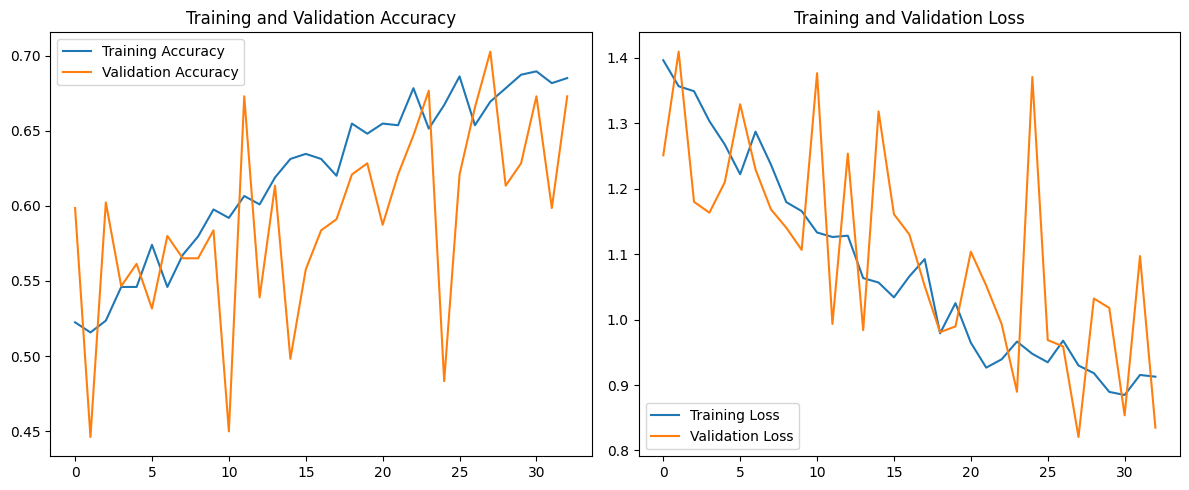

In [71]:
# Display the accuracy and loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Show the plots
plt.tight_layout()
plt.show()

## Model Evaluation

### Evaluate on test set

In [72]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7512 - loss: 0.8244
Test Accuracy: 0.7048
Test Loss: 0.9060


### Display accuracy, precision, recall, and F1-score

In [73]:
import numpy as np
from sklearn.metrics import classification_report

# Get the true labels from test generator
y_true = test_generator.classes

# Get predicted probabilities
y_pred_probs = model.predict(test_generator)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 684ms/step
Classification Report:
               precision    recall  f1-score   support

       blues       0.69      0.81      0.75        27
   classical       0.92      0.92      0.92        25
     country       0.67      0.74      0.70        27
       disco       0.73      0.41      0.52        27
      hiphop       0.83      0.77      0.80        26
        jazz       0.94      0.61      0.74        28
       metal       0.90      0.93      0.92        29
         pop       0.72      0.72      0.72        25
      reggae       0.41      0.79      0.54        29
        rock       0.62      0.36      0.45        28

    accuracy                           0.70       271
   macro avg       0.74      0.71      0.71       271
weighted avg       0.74      0.70      0.70       271



### Generate a confusion matrix

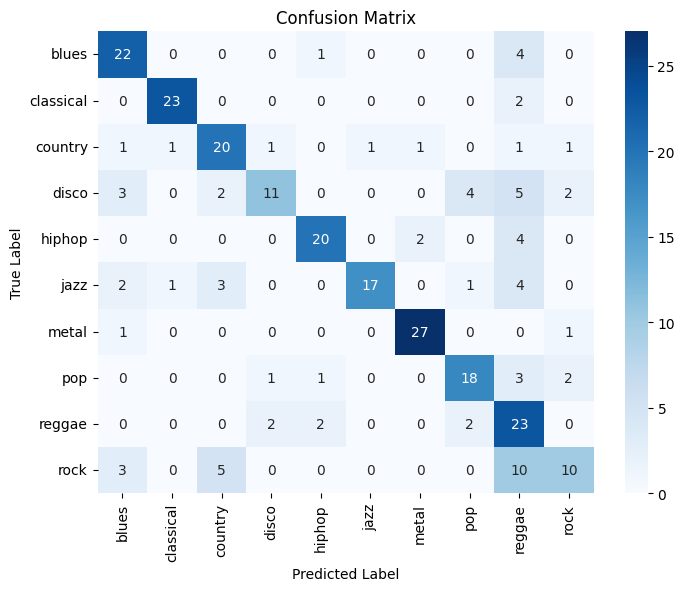

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Observation**
* The model achieved a test accuracy of 70.48%, with a corresponding test loss of 0.9060.
* Based on the classification report, we can see that
    * Classical had the highest consistency with precision 0.92 and recall 0.92.
    * Metal also stood out with precision 0.90 and recall 0.93.
    * Hiphop performed solid with precision 0.83 and recall 0.77.
    * Whereas, genres like disco (recall 0.41), rock (recall 0.36), and reggae (precision 0.41) were more error-prone.
* We can also see this in the confusion matrix: 
    * Disco (true label) was often misclassified as pop (4) and reggae (5).
    * Rock was misclassified as country (5) and reggae (10), correctly predicted only 10/28 times.
    * Jazz was confused with country (3) and pop (4) despite relatively high precision.
    * Meanwhile, genres like classical, metal, and hiphop had high correct counts (23, 27, and 20, respectively) with fewer off-class predictions.
* Overall, our baseline CNN model performs reasonably well, but we are going to proceed with hyperparameter tuning to get the best results. 

## Hyperparameter Tuning

**Approach**

* To improve performance, we experimented with a few hyperparameters during training:
    * Added another convolutional layer to increase model depth and capture more complex patterns.
    * Tuned the dropout rate to reduce overfitting without hurting learning capacity.
    * Adjusted the learning rate to stabilize training and prevent sudden spikes in loss.
    * Included a learning rate scheduler `ReduceLROnPlateau` so that the model could dynamically lower the learning rate when validation loss plateaued — giving it a better shot at converging.

### Add another Conv layer

In [ ]:
# Define the model 
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 298, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 149, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 147, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 73, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 71, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 35, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 33, 46, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 94208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    24,117,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,540,106 (93.61 MB)

 Trainable params: 24,540,106 (93.61 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Get the class labels from the training generator
labels = train_generator.classes

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define callbacks
os.makedirs("models", exist_ok=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'cnn_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Add LR scheduler for dynamic learning rate adjustment
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, lr_scheduler]

In [80]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.1114 - loss: 2.3312 - val_accuracy: 0.1933 - val_loss: 2.2679 - learning_rate: 1.0000e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.1623 - loss: 2.2505 - val_accuracy: 0.2305 - val_loss: 2.0795 - learning_rate: 1.0000e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.1793 - loss: 2.1678 - val_accuracy: 0.2416 - val_loss: 2.0173 - learning_rate: 1.0000e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.2510 - loss: 2.0919 - val_accuracy: 0.3086 - val_loss: 1.9001 - learning_rate: 1.0000e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.2723 - loss: 1.9442 - val_accuracy: 0.3383 - val_loss: 1.8364 - learning_rate: 1.0000e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.2828 - loss: 1.9049 - val_accuracy: 0.4126 - val_loss: 1.7298 - learning_rate: 1.0000e-04
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.3013 - lo

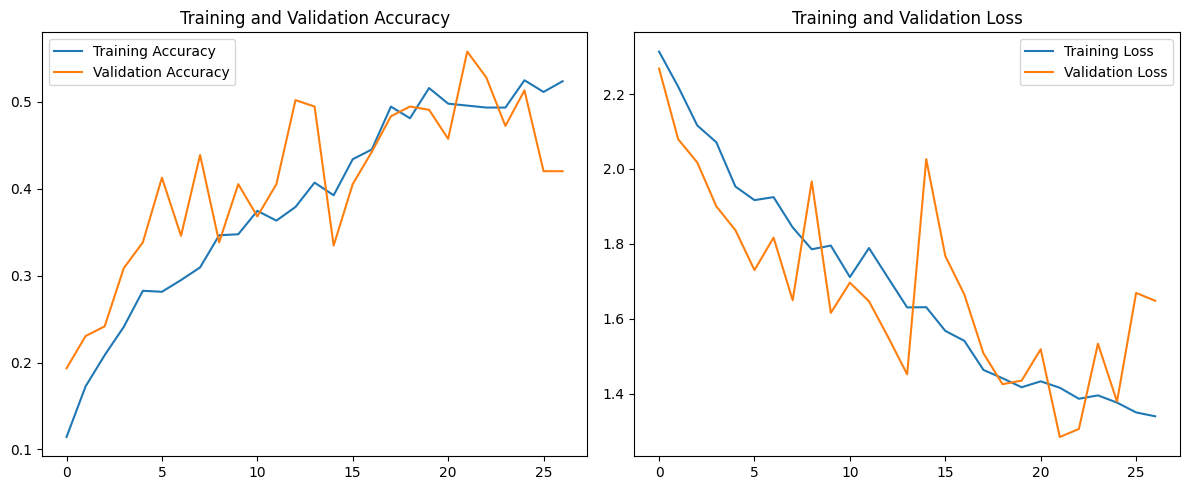

In [82]:
# Display the accuracy and loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Show the plots
plt.tight_layout()
plt.show()

### Evaluate tuning results on test set 

In [83]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.5742 - loss: 1.2962
Test Accuracy: 0.5720
Test Loss: 1.4112


### Load keras models

**Approach**
* We saved our tuned CNN model using Keras' built-in `model.save()` method to ensure it can be reliably reloaded during deployment. 
* We decided not to use `pickle` since Keras models require a dedicated format.

In [85]:
from tensorflow.keras.models import load_model

# Load baseline model
model = load_model("models/cnn_baseline.keras")